In [1]:
import os
import time
from PIL import Image
from master_encoder_gray import save_decoded_image as save_decoded_image_gray
from master_encoder_rgb import save_decoded_image as save_decoded_image_rgb
from master_encoder_sbw import save_decoded_image as save_decoded_image_bw
from master_encoder_rgba import save_decoded_image as save_decoded_image_rgba
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [5]:
def classify_image_type(image_path):
    try:
        img = Image.open(image_path)
        mode = img.mode
        if mode == '1':
            return 'BW'
        elif mode == 'L':
            arr = np.array(img)
            unique_vals = np.unique(arr)
            if np.array_equal(unique_vals, [0, 255]) or np.array_equal(unique_vals, [0]) or np.array_equal(unique_vals, [255]):
                return 'BW'
            return 'Grayscale'
        elif mode == 'RGBA':
            return 'RGBA'
        elif mode == 'RGB':
            arr = np.array(img)
            if np.all(arr[:, :, 0] == arr[:, :, 1]) and np.all(arr[:, :, 1] == arr[:, :, 2]):
                unique_vals = np.unique(arr[:, :, 0])
                if np.array_equal(unique_vals, [0, 255]) or np.array_equal(unique_vals, [0]) or np.array_equal(unique_vals, [255]):
                    return 'BW'
                return 'Grayscale'
            return 'RGB'
        else:
            return 'Unknown'
    except Exception as e:
        print(f"❌ Error classifying image {image_path}: {e}")
        return 'Unknown'

def get_file_size_kb(path):
    try:
        return os.path.getsize(path) / 1024.0
    except FileNotFoundError:
        return 0.0  # Or some other sentinel value

def benchmark_folder(image_folder, output_csv="benchmark_results.csv"):
    results = []
    output_dir = os.path.join("enc_op", "benchmark_test")
    os.makedirs(output_dir, exist_ok=True)  # Create the main output directory

    # Create subdirectories
    for root, dirs, files in os.walk(image_folder):
        rel_path = os.path.relpath(root, image_folder)
        out_path = os.path.join(output_dir, rel_path)
        os.makedirs(out_path, exist_ok=True)

    for root, dirs, files in os.walk(image_folder):
        for filename in files:
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            input_path = os.path.join(root, filename)

            image_type = classify_image_type(input_path)
            name, _ = os.path.splitext(filename)
            rel_path = os.path.relpath(root, image_folder)
            out_path = os.path.join(output_dir, rel_path, f"{name}_decompressed.png" if image_type == "RGBA" else f"{name}_decompressed.jpg")

            start_enc = time.time()
            output_size = 0.0

            try:
                if image_type == 'BW':
                    save_decoded_image_bw(input_path, out_path, save_intermediate=False)
                elif image_type == 'Grayscale':
                    save_decoded_image_gray(input_path, out_path, save_intermediate=False)
                elif image_type == 'RGB':
                    save_decoded_image_rgb(input_path, out_path, save_intermediate=False)
                elif image_type == 'RGBA':
                    save_decoded_image_rgba(input_path, out_path, save_intermediate=False)
                else:
                    print(f"❌ Skipping unsupported image: {filename}")
                    continue

                start_wait = time.time()
                wait_time = 0
                while not os.path.exists(out_path) and wait_time < 5:
                    time.sleep(0.1)
                    wait_time = time.time() - start_wait

                if os.path.exists(out_path):
                    output_size = get_file_size_kb(out_path)
                else:
                    print(f"❌ Decompressed image not found after waiting: {out_path}")

            except Exception as e:
                print(f"❌ Error encoding/decoding {filename}: {e}")

            end_enc = time.time()
            original_size = get_file_size_kb(input_path)
            compression_time = round(end_enc - start_enc, 3)
            category = os.path.basename(root)

            results.append([filename, category, image_type, original_size, output_size, compression_time])
            # print(f"✅ Processed {filename}: Original: {original_size:.2f} KB, Decompressed: {output_size:.2f} KB, Time: {compression_time:.3f} sec")

    df = pd.DataFrame(results, columns=["Filename", "Category", "Type", "Original_KB", "Decompressed_KB", "Time_sec"])
    df.to_csv(output_csv, index=False)
    print(f"✅ Benchmark complete. Results saved to {output_csv}")

    return df

In [3]:
def analyze_and_visualize(df):
    """Analyzes the benchmark data and generates visualizations."""

    # 1. Basic Statistics
    print("\n📊 Descriptive Statistics:")
    print(df.describe())

    # 2. Plotting with Seaborn (more visually appealing)
    sns.set(style="whitegrid")  # Optional styling
    plt.figure(figsize=(12, 6))

    # Plot compression times by image type
    sns.barplot(x="Type", y="Time_sec", data=df, palette="viridis")
    plt.title("Compression Time by Image Type")
    plt.xlabel("Image Type")
    plt.ylabel("Compression Time (seconds)")
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.savefig("compression_time_by_type.png")
    print("✅ Generated compression time graph: compression_time_by_type.png")
    plt.show()

    # Plot original vs decompressed size (scatter plot)
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x="Original_KB", y="Decompressed_KB", hue="Type", data=df, palette="muted")
    plt.title("Original Size vs. Decompressed Size")
    plt.xlabel("Original Size (KB)")
    plt.ylabel("Decompressed Size (KB)")
    plt.tight_layout()
    plt.savefig("original_vs_decompressed.png")
    print("✅ Generated size comparison graph: original_vs_decompressed.png")
    plt.show()

     # Compression ratio calculation and boxplot by category
    df['Compression_Ratio'] = df['Original_KB'] / df['Decompressed_KB']
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Category", y="Compression_Ratio", data=df)
    plt.title("Compression Ratio by Category")
    plt.xlabel("Category")
    plt.ylabel("Compression Ratio (Original/Decompressed)")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig("compression_ratio_by_category.png")
    print("✅ Generated compression ratio by category: compression_ratio_by_category.png")
    plt.show()

    # 3. Statistical Tests (Example: Comparing Compression Times between two image types)
    # You'll need to adjust this based on what you want to compare
    print("\n🔬 Statistical Analysis:")
    image_types = df["Type"].unique() # Get a unique list of image types

    if len(image_types) >= 2:  # Ensure at least two image types exist
        type1 = image_types[0]  #Example
        type2 = image_types[1]  #Example
        data1 = df[df["Type"] == type1]["Time_sec"]
        data2 = df[df["Type"] == type2]["Time_sec"]

        if len(data1) > 0 and len(data2) > 0: #Ensure there's data to actually compare
            t_statistic, p_value = stats.ttest_ind(data1, data2) #Independent samples t-test (assuming data are independent)
            print(f"T-test between {type1} and {type2} compression times:")
            print(f"  T-statistic: {t_statistic:.3f}")
            print(f"  P-value: {p_value:.3f}")

            if p_value < 0.05:
                print("  Conclusion: There is a statistically significant difference in compression times.")
            else:
                print("  Conclusion: There is no statistically significant difference in compression times.")
        else:
            print(f"Skipping T-test: Insufficient data for {type1} or {type2}")
    else:
        print("Skipping T-test:  Not enough image types for comparison.")

In [ ]:
if __name__ == "__main__":
    image_folder = "./test_images"
    output_csv = "benchmark_results.csv"

df = benchmark_folder(image_folder, output_csv)


📊 Descriptive Statistics:
       Original_KB  Decompressed_KB   Time_sec
count    80.000000        80.000000  80.000000
mean      5.042432         5.557385   0.066388
std       3.889986         3.984823   0.050362
min       1.504883         1.501953   0.008000
25%       2.673828         2.722168   0.019000
50%       3.414551         4.117676   0.051500
75%       5.794922         6.817627   0.105000
max      17.853516        17.853516   0.220000
✅ Generated compression time graph: compression_time_by_type.png


C:\Users\ELIXPO\AppData\Local\Temp\ipykernel_17884\3642886575.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Type", y="Time_sec", data=df, palette="viridis")


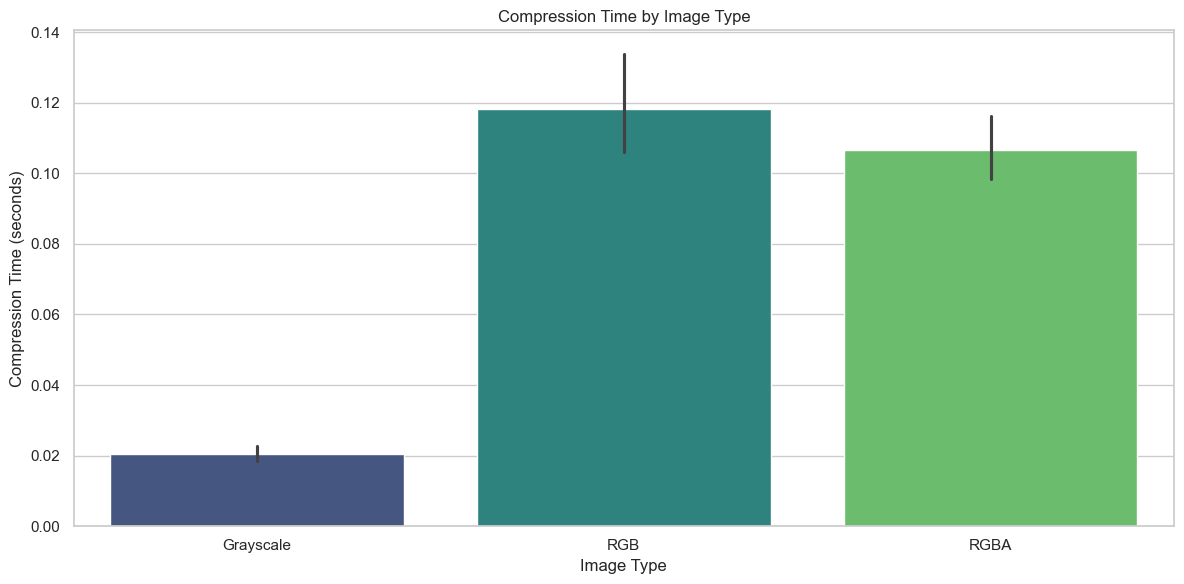

✅ Generated size comparison graph: original_vs_decompressed.png


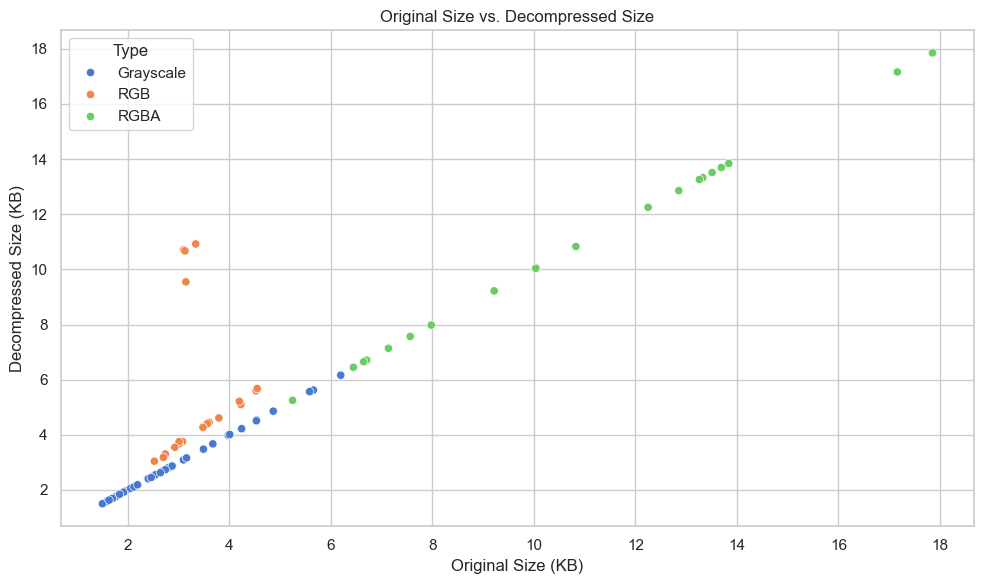

✅ Generated compression ratio by category: compression_ratio_by_category.png


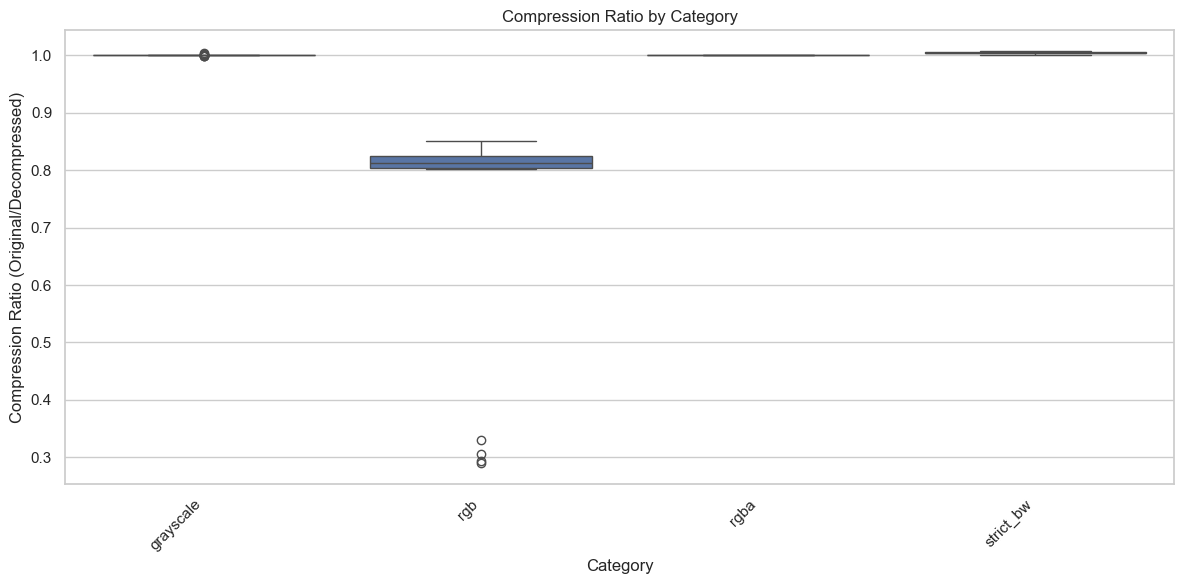


🔬 Statistical Analysis:
T-test between Grayscale and RGB compression times:
  T-statistic: -18.893
  P-value: 0.000
  Conclusion: There is a statistically significant difference in compression times.


In [8]:
analyze_and_visualize(df)